# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np 
import json
import requests
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore
from scipy import stats

In [2]:
# Load dataframe created in data wrangling phase
# Parse datetime column and make index
df= pd.read_csv('cleaned_cov_weather4.csv', parse_dates=['date'], index_col ='date')

In [3]:
df.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,-28,0,-72.0,0.0,-76.0,0.0,-53.0,0.0,0,0,0,0
2020-01-23,-27,0,-30.0,3.0,-46.0,0.0,0.0,0.0,0,0,0,0
2020-01-24,-8,0,-14.0,0.0,6.0,0.0,19.0,0.0,0,0,0,0
2020-01-25,3,119,-30.0,3.0,23.0,218.0,33.0,25.0,0,0,0,0
2020-01-26,22,23,11.0,132.0,49.0,0.0,64.0,193.0,0,0,0,0


In [4]:
# Check for duplicated DateTimeIndices
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-29,44,0,19.0,0.0,46.0,0.0,50.0,0.0,112581,11508,224964,4100
2020-11-30,61,170,53.0,503.0,57.0,478.0,80.0,122.0,117295,11757,226132,4172


In [5]:
# Remove duplicated DateTimeIndices (but keep first instances of indices)
# Check to confirm duplicated indices have been removed 
df = df[~df.index.duplicated(keep='first')]
df[df.index.duplicated()]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


In [6]:
#double check data types
df.dtypes

vt_avg_temp        int64
vt_prcp            int64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases      int64
ME_conf_cases      int64
MA_conf_cases      int64
VT_conf_cases      int64
dtype: object

In [7]:
#Convert int columns to float in preparation for calculations:
int_columns= {"CT_conf_cases": 'float', "ME_conf_cases": 'float', "MA_conf_cases":"float", "VT_conf_cases":'float', "vt_avg_temp":'float', "vt_prcp":'float'}
df = df.astype(int_columns)

In [8]:
df.dtypes

vt_avg_temp      float64
vt_prcp          float64
me_avg_temp      float64
me_prcp          float64
ct_avg_temp      float64
ct_prcp          float64
ma_avg_temp      float64
ma_prcp          float64
CT_conf_cases    float64
ME_conf_cases    float64
MA_conf_cases    float64
VT_conf_cases    float64
dtype: object

In [9]:
#Any missing values?
df[pd.isnull(df).any(axis=1)]

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,


No missing values.

However, the units of TAVG and PRCP are clearly off. 

According to [NOAA documentation](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt), temperatures are reported in __*tenths*__ of a degree Celsius. I'll convert to degrees Fahrenheit instead (since this is US data here).

In [10]:
# (C*9/50)+32=F (since C is reported here as tenths of degrees)
df2=df
df2['vt_avg_temp'] = ((df['vt_avg_temp']*9)/50) + 32
df2['me_avg_temp'] = ((df['me_avg_temp']*9)/50) + 32
df2['ct_avg_temp'] = ((df['ct_avg_temp']*9)/50) + 32
df2['ma_avg_temp'] = ((df['ma_avg_temp']*9)/50) + 32

The [same documention](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) cited above also explains that PRCP data is reported in __*tenths*__ of a mm. [Wikipedia](https://en.wikipedia.org/wiki/Precipitation) reports that generally PRCP data is reported in millimeters, so I'll convert to millimeters instead.

In [11]:
df3=df2
df3['vt_prcp'] = df2['vt_prcp']/10
df3['me_prcp'] = df2['me_prcp']/10
df3['ct_prcp'] = df2['ct_prcp']/10
df3['ma_prcp'] = df2['ma_prcp']/10

In [12]:
df3.head()

,vt_avg_temp,vt_prcp,me_avg_temp,me_prcp,ct_avg_temp,ct_prcp,ma_avg_temp,ma_prcp,CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


For the sake of clarity, I'll update column names to reflect this unit change.

In [13]:
#Update column names to reflect new units:
units_dict= {'vt_avg_temp': 'VT_Avg_Temp(F)', 'vt_prcp': 'VT_PRCP(mm)', 'me_avg_temp':'ME_Avg_Temp(F)', 'me_prcp': 'ME_PRCP(mm)', 'ct_avg_temp': 'CT_Avg_Temp(F)', 'ct_prcp':'CT_PRCP(mm)', 'ma_avg_temp': 'MA_Avg_Temp(F)', 'ma_prcp':'MA_PRCP(mm)'}
df3.rename(columns=units_dict, inplace=True)
df3.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_conf_cases,ME_conf_cases,MA_conf_cases,VT_conf_cases
date,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0
2020-01-25,32.54,11.9,26.60,0.3,36.14,21.8,37.94,2.5,0.0,0.0,0.0,0.0
2020-01-26,35.96,2.3,33.98,13.2,40.82,0.0,43.52,19.3,0.0,0.0,0.0,0.0


In [14]:
#Examine timespan of data:
print('Beginning date: ',min(df3.index))
print('End date: ', max(df3.index))
print('Total timespan: ', max(df3.index-min(df3.index)))

Beginning date:  2020-01-22 00:00:00
End date:  2021-09-12 00:00:00
Total timespan:  599 days 00:00:00


In [15]:
# Make copy of df 
df4=df3

The confirmed cases column represented total number of cumulative new COVID cases per date. To explore infection rate changes over time, rather than cumulatively, we'll have to take the first differences of the cumulative counts.

In [16]:
# Make column of non-cumulative counts of confirmed cases for each state:
df4["CT_Conf_Cases"] = df4['CT_conf_cases'].diff().fillna(0)
df4["VT_Conf_Cases"] = df4['VT_conf_cases'].diff().fillna(0)
df4["ME_Conf_Cases"] = df4['ME_conf_cases'].diff().fillna(0)
df4["MA_Conf_Cases"] = df4['MA_conf_cases'].diff().fillna(0)

In [17]:
#Drop cumulative confirmed case columns:
df5 = df4.drop(columns=['CT_conf_cases', 'VT_conf_cases', 'ME_conf_cases', 'MA_conf_cases'])

In [18]:
#Take a look at some summary statistics of the data:
df5.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,51.115400,2.239833,45.224000,2.853500,54.263300,3.502333,54.381950,3.787833,631.555000,50.190000,134.188333,1295.036667
std,19.936095,5.804667,19.548057,8.950529,17.516293,10.068826,16.950279,10.299207,1110.107736,63.347234,171.873540,1568.531084
min,2.120000,0.000000,-1.840000,0.000000,11.660000,0.000000,14.000000,0.000000,-15.000000,-1.000000,-1.000000,-280.000000
25%,35.060000,0.000000,30.020000,0.000000,39.155000,0.000000,39.920000,0.000000,0.000000,3.000000,18.000000,200.750000
50%,51.980000,0.000000,46.760000,0.000000,55.580000,0.000000,55.040000,0.000000,165.500000,13.500000,42.000000,658.500000
75%,68.000000,1.300000,62.150000,1.300000,70.160000,1.300000,68.630000,2.000000,738.750000,94.000000,211.000000,1884.250000
max,84.920000,63.500000,80.060000,131.100000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,9003.000000


It looks like some of the states have `Conf_Cases` values that are less than zero (see `min` row). That can't be right; I'll replace them with zeroes instead.

In [19]:
#Replace negative values with zeroes:
#df5[df5 < 0] = 0

A quick look at the tail of the DataFrame reveals another interesting detail:

In [20]:
df5['CT_Conf_Cases'].tail(25)

date
2021-08-19     534.0
2021-08-20     431.0
2021-08-21       0.0
2021-08-22       0.0
2021-08-23    1554.0
2021-08-24    1071.0
2021-08-25     651.0
2021-08-26     788.0
2021-08-27     788.0
2021-08-28       0.0
2021-08-29       0.0
2021-08-30    1361.0
2021-08-31    1003.0
2021-09-01     712.0
2021-09-02     686.0
2021-09-03     665.0
2021-09-04       0.0
2021-09-05       0.0
2021-09-06       0.0
2021-09-07    1612.0
2021-09-08     935.0
2021-09-09     626.0
2021-09-10     625.0
2021-09-11       0.0
2021-09-12       0.0
Name: CT_Conf_Cases, dtype: float64

It looks like, for every five days of values for `Conf_Cases`, there are two days of zero values. A quick calendar check confirms that the dates corresponding to zero values are weekend dates (besides 09/06/21, which was Labor Day- a bank holiday in the US). Because there is only data for weekdays, I'll remove weekend data, as it can only skew our summary statistics and plots.

In [21]:
#Create column to designate day of week:
df6= df5
df6["weekday"] = df6.index.dayofweek

In [22]:
#Filter DataFrame to only include weekdays (days 0-4)
df6 = df6[(df6.weekday != 5) & (df6.weekday != 6)]

Another quick check of the summary statistics:

In [23]:
df6.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,51.352944,2.350701,45.453832,2.884112,54.584533,3.819860,54.676636,3.972897,848.925234,49.700935,144.616822,1355.306075,2.007009
std,19.773542,5.932523,19.587352,7.677247,17.315077,10.523025,16.860718,10.675497,1227.692664,62.088848,185.062374,1531.337397,1.415024
min,2.120000,0.000000,0.000000,0.000000,13.100000,0.000000,17.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,29.885000,0.000000,39.335000,0.000000,40.325000,0.000000,113.500000,4.000000,18.000000,258.750000,1.000000
50%,51.980000,0.000000,46.940000,0.000000,55.760000,0.000000,55.400000,0.000000,431.500000,14.500000,41.500000,830.000000,2.000000
75%,68.000000,1.300000,62.555000,1.575000,70.160000,1.800000,68.630000,2.500000,1064.250000,91.250000,223.250000,1987.000000,3.000000
max,84.920000,63.500000,80.060000,68.800000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,8120.000000,4.000000


In [24]:
df6.head()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
date,,,,,,,,,,,,,
2020-01-22,26.96,0.0,19.04,0.0,18.32,0.0,22.46,0.0,0.0,0.0,0.0,0.0,2
2020-01-23,27.14,0.0,26.60,0.3,23.72,0.0,32.00,0.0,0.0,0.0,0.0,0.0,3
2020-01-24,30.56,0.0,29.48,0.0,33.08,0.0,35.42,0.0,0.0,0.0,0.0,0.0,4
2020-01-27,34.52,1.3,31.46,1.0,38.84,0.0,39.02,0.0,0.0,0.0,0.0,0.0,0
2020-01-28,30.02,0.3,21.56,0.0,36.68,0.0,37.40,0.0,0.0,0.0,0.0,0.0,1


In [25]:
#Create a list of US bank holidays in 2020-2021:
#Please refer to note below, explaining how this list of dates was put together.
US_bank_holidays = ['2020-02-17', '2020-12-25', '2020-11-26', '2020-12-25', '2021-01-01', '2021-05-31', '2021-09-06']

Full list of 2020 US Holidays [here](https://www.officeholidays.com/countries/usa/2020).
Full list of 2021 US Holidays [here](https://www.officeholidays.com/countries/usa/2021).\
__Note:__ Not all bank holidays listed in the above resources appear in my `US_bank_holidays` list. I used the resources above as a general guide of dates that might not contain any data, and then checked each of the dates individually to make sure I wasn't deleting any significant data from the set. I found that data __was__ recorded for some of the bank holidays listed in the resources; whenever this was the case, I did __not__ drop that row of data. The dates listed in `US_bank_holidays` reflect only those bank holidays listed in these resources that I was __also__ able to confirm did not have any significant data.

In [26]:
#Drop rows with indices in US_bank_holidays list:
df7= df6.drop(df6[(df6.index.isin(US_bank_holidays))].index)

In [27]:
#Check rows have been dropped:
print(len(df6.index))
print(len(df7.index))

428
422


In [28]:
#Recheck summary statistics with dropped US_bank_holidays:
df7.describe()

,VT_Avg_Temp(F),VT_PRCP(mm),ME_Avg_Temp(F),ME_PRCP(mm),CT_Avg_Temp(F),CT_PRCP(mm),MA_Avg_Temp(F),MA_PRCP(mm),CT_Conf_Cases,VT_Conf_Cases,ME_Conf_Cases,MA_Conf_Cases,weekday
count,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000,422.000000
mean,51.449384,2.295972,45.547441,2.679384,54.662938,3.676777,54.728626,3.907109,860.995261,50.071090,143.587678,1374.575829,2.009479
std,19.821554,5.902792,19.610835,6.986919,17.355393,10.267171,16.897177,10.645570,1232.190350,62.186026,183.795638,1533.578792,1.407447
min,2.120000,0.000000,0.000000,0.000000,13.100000,0.000000,17.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.060000,0.000000,30.020000,0.000000,39.380000,0.000000,40.460000,0.000000,115.000000,4.000000,18.000000,266.250000,1.000000
50%,52.430000,0.000000,46.940000,0.000000,55.760000,0.000000,55.400000,0.000000,445.500000,15.000000,41.000000,867.500000,2.000000
75%,68.270000,1.300000,62.825000,1.500000,70.160000,1.725000,68.810000,2.450000,1069.500000,91.750000,220.500000,2014.000000,3.000000
max,84.920000,63.500000,80.060000,58.200000,85.640000,103.400000,87.980000,95.000000,8457.000000,357.000000,824.000000,8120.000000,4.000000


In [29]:
# save the data to a new csv file
df7.to_csv('state_cov_weather.csv')

## Plots:

With so many twin axes to plot, I'll define a function to help plot all of twin axes time series data:

In [30]:
def plot_timeseries(axes, x, y, color, xlabel, ylabel):
    axes.plot(x,y,color=color)
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.tick_params('y', colors = color)

## Connecticut

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

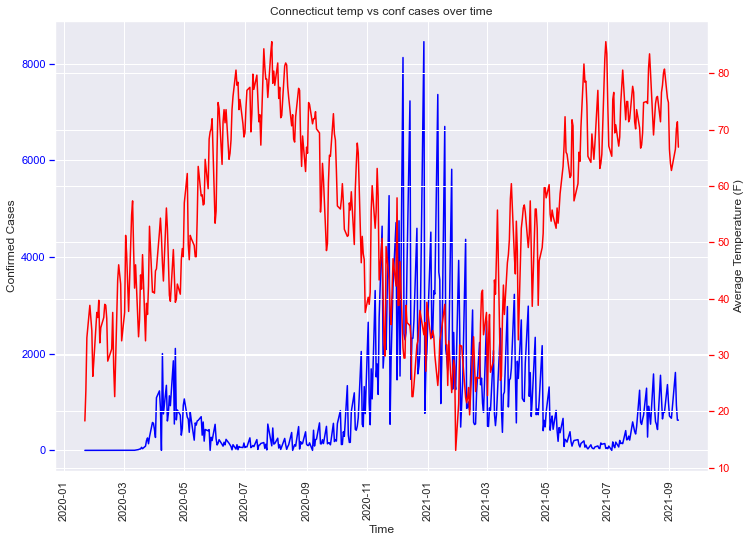

In [32]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT temp vs time
plot_timeseries(ax2, df7.index, df7['CT_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Connecticut temp vs conf cases over time')
plt.xticks(rotation=90)
plt.show()

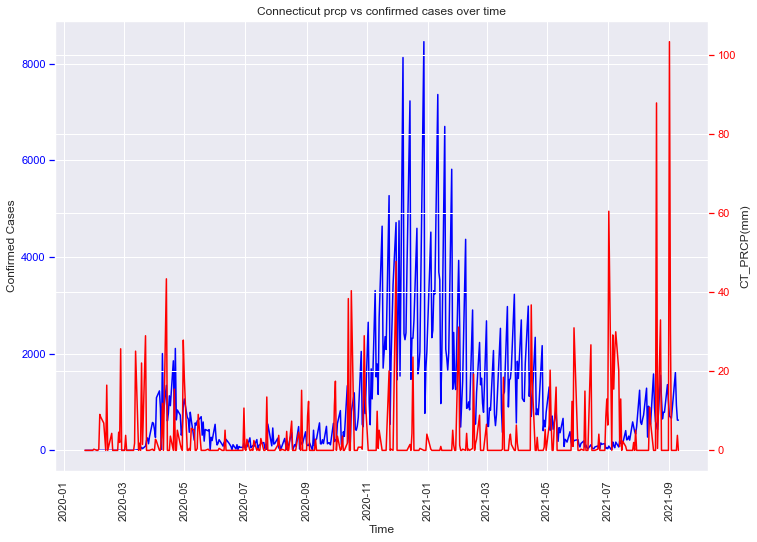

In [33]:
#Plot CT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['CT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot CT prcp vs time
plot_timeseries(ax2, df7.index, df7['CT_PRCP(mm)'], 'red', 'Time', 'CT_PRCP(mm)')
plt.title('Connecticut prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

***

## Maine

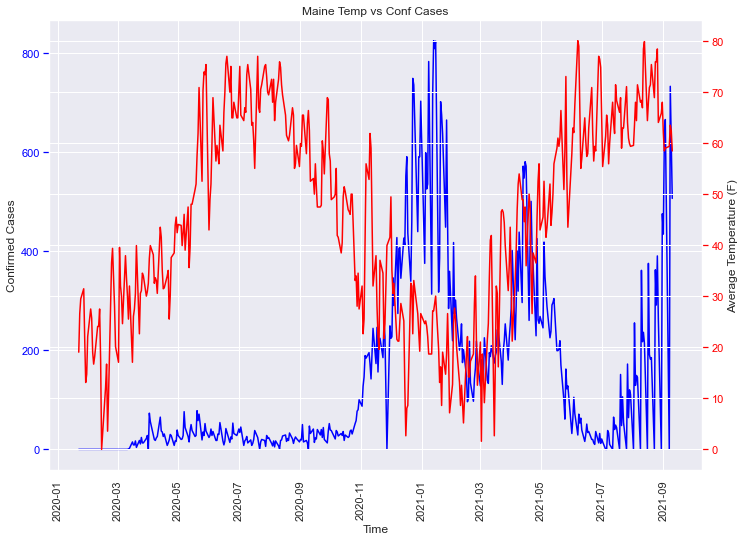

In [34]:
#Plot ME time vs Avg. Temp 
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
plot_timeseries(ax2, df7.index, df7['ME_Avg_Temp(F)'], 'red', 'Time', 'Average Temperature (F)')
plt.title('Maine Temp vs Conf Cases')
plt.xticks(rotation=90)
plt.show()

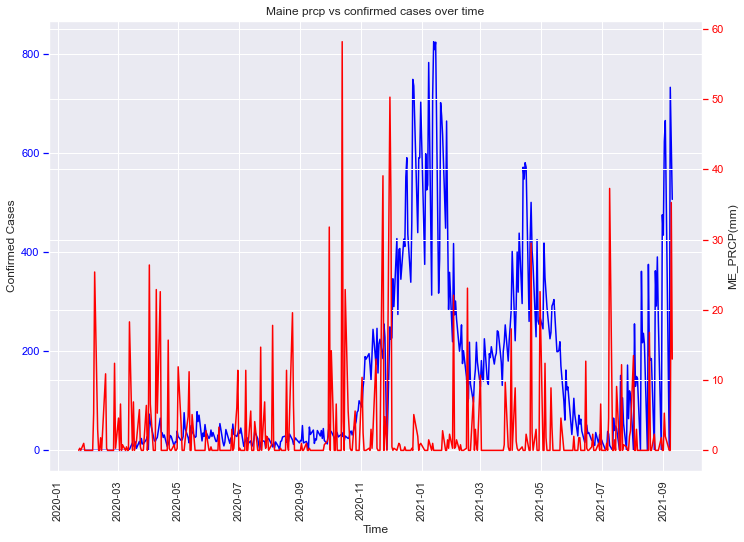

In [35]:
#Plot ME time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['ME_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot ME prcp vs time
plot_timeseries(ax2, df7.index, df7['ME_PRCP(mm)'], 'red', 'Time', 'ME_PRCP(mm)')
plt.title('Maine prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Massachusetts

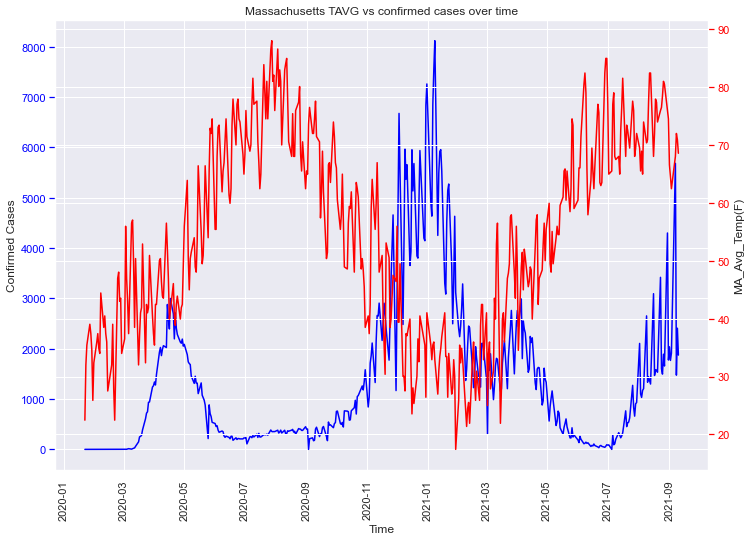

In [36]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA temp vs time
plot_timeseries(ax2, df7.index, df7['MA_Avg_Temp(F)'], 'red', 'Time', 'MA_Avg_Temp(F)')
plt.title('Massachusetts TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

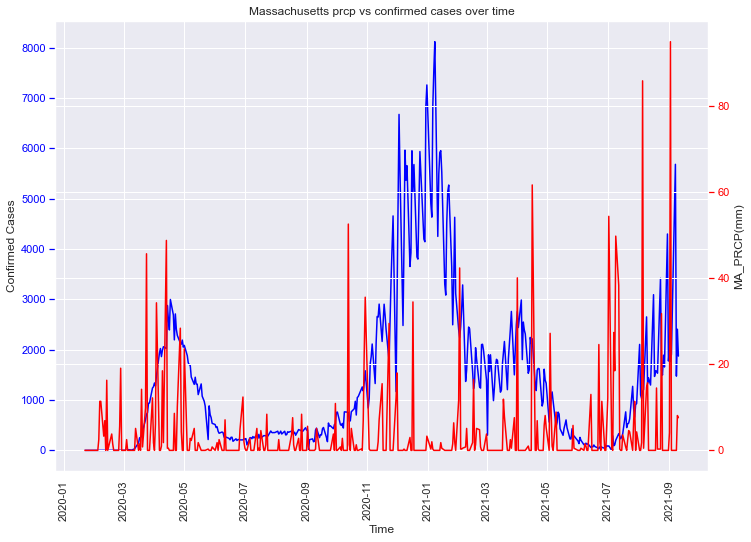

In [37]:
#Plot MA time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['MA_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df7.index, df7['MA_PRCP(mm)'], 'red', 'Time', 'MA_PRCP(mm)')
plt.title('Massachusetts prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Vermont

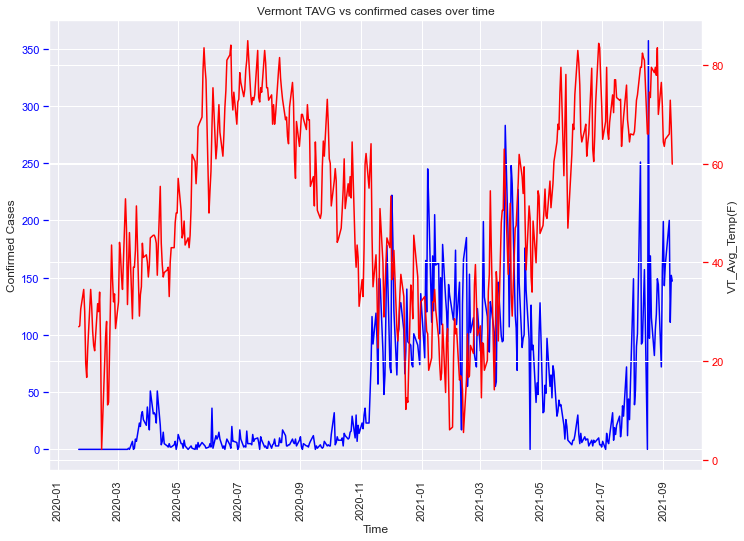

In [38]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot VT temp vs time
plot_timeseries(ax2, df7.index, df7['VT_Avg_Temp(F)'], 'red', 'Time', 'VT_Avg_Temp(F)')
plt.title('Vermont TAVG vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

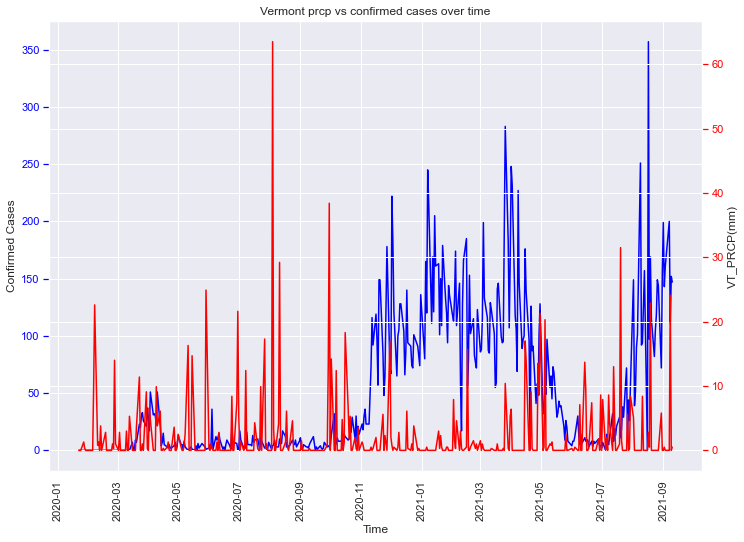

In [39]:
#Plot VT time vs confirmed cases
fig, ax = plt.subplots()
plot_timeseries(ax, df7.index, df7['VT_Conf_Cases'], 'blue', 'Time', 'Confirmed Cases')
plt.xticks(rotation=90)
ax2 = ax.twinx()
#Plot MA prcp vs time
plot_timeseries(ax2, df7.index, df7['VT_PRCP(mm)'], 'red', 'Time', 'VT_PRCP(mm)')
plt.title('Vermont prcp vs confirmed cases over time')
plt.xticks(rotation=90)
plt.show()

## Perform Shapiro-Wilk test for normality:

In [40]:
#Convert dataframe to array to perform Shapiro-Wilcox test:
np_cov_weather7 = df7.to_numpy()

In [41]:
#Apply Shapiro test:
shapiro_test = stats.shapiro(np_cov_weather7)

/Users/abigailmorgan/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [42]:
#Print values:
print("Shapiro test statistic is: ", shapiro_test.statistic)
print("Shapiro p-value is: ", shapiro_test.pvalue)

Shapiro test statistic is:  0.31386470794677734
Shapiro p-value is:  0.0


## Predictive Power Score:

In [43]:
#Calculate ppscore 
pps = ppscore.matrix(df7)

In [44]:
print(pps)

                  x               y   ppscore            case  is_valid_score  \
0    VT_Avg_Temp(F)  VT_Avg_Temp(F)  1.000000  predict_itself            True   
1    VT_Avg_Temp(F)     VT_PRCP(mm)  0.000000      regression            True   
2    VT_Avg_Temp(F)  ME_Avg_Temp(F)  0.769194      regression            True   
3    VT_Avg_Temp(F)     ME_PRCP(mm)  0.000000      regression            True   
4    VT_Avg_Temp(F)  CT_Avg_Temp(F)  0.695178      regression            True   
..              ...             ...       ...             ...             ...   
164         weekday   CT_Conf_Cases  0.000000      regression            True   
165         weekday   VT_Conf_Cases  0.000000      regression            True   
166         weekday   ME_Conf_Cases  0.000000      regression            True   
167         weekday   MA_Conf_Cases  0.000000      regression            True   
168         weekday         weekday  1.000000  predict_itself            True   

                  metric  b

In [45]:
print(df7.dtypes)

VT_Avg_Temp(F)    float64
VT_PRCP(mm)       float64
ME_Avg_Temp(F)    float64
ME_PRCP(mm)       float64
CT_Avg_Temp(F)    float64
CT_PRCP(mm)       float64
MA_Avg_Temp(F)    float64
MA_PRCP(mm)       float64
CT_Conf_Cases     float64
VT_Conf_Cases     float64
ME_Conf_Cases     float64
MA_Conf_Cases     float64
weekday             int64
dtype: object


In [46]:
matrix_df = ppscore.matrix(df7).pivot(columns='x', index='y',  values='ppscore')

<AxesSubplot:xlabel='x', ylabel='y'>

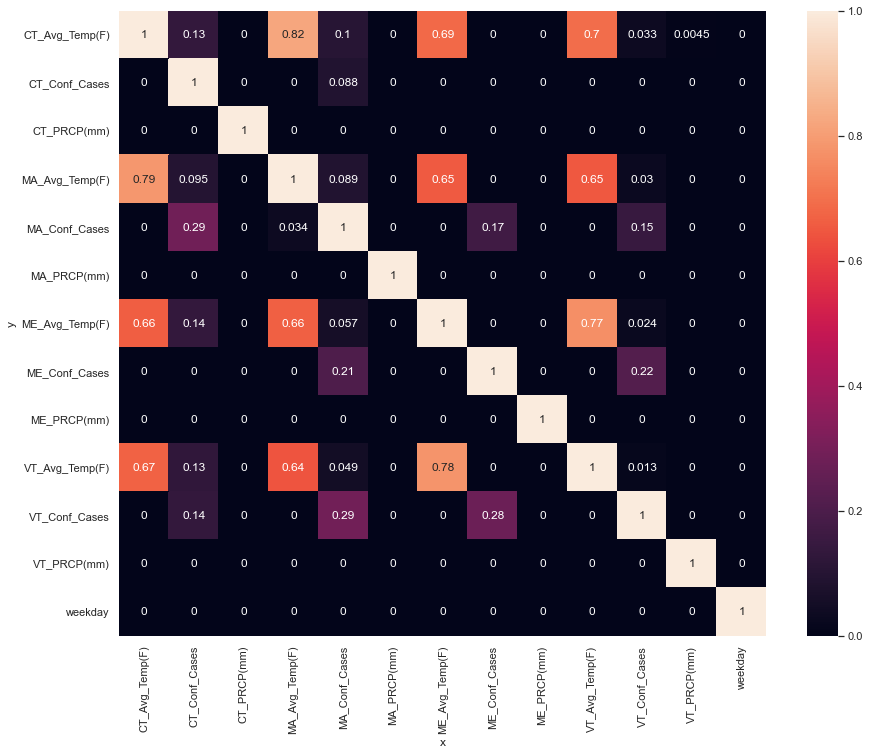

In [47]:
sns.set(rc={'figure.figsize':(14.5,11.5)})
sns.heatmap(matrix_df, annot= True)

<AxesSubplot:>

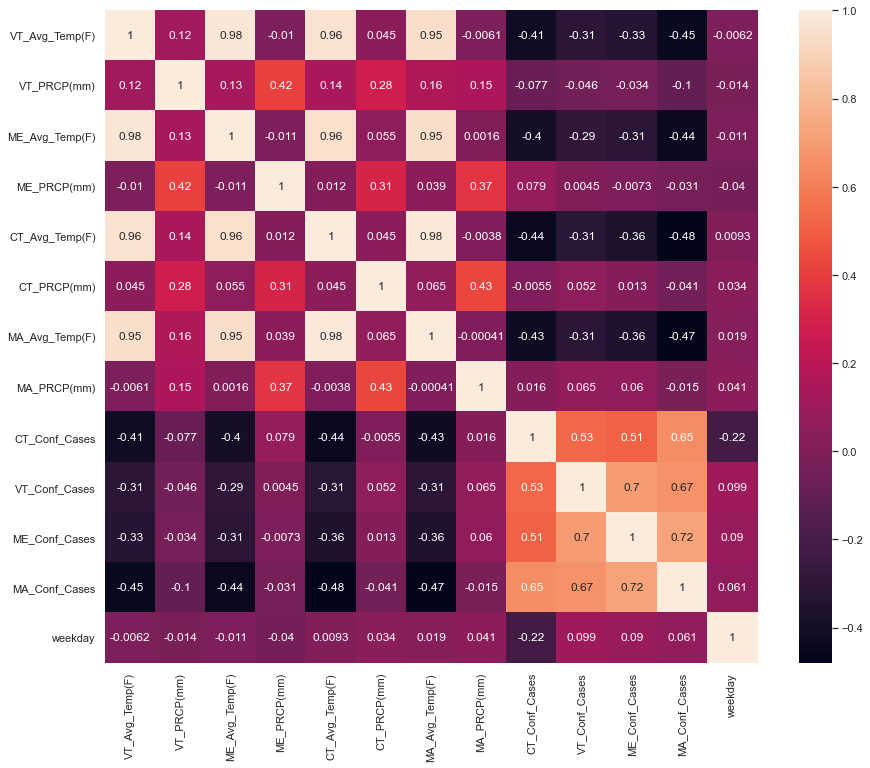

In [48]:
sns.set(rc={'figure.figsize':(15,12)})
sns.heatmap(df7.corr(), square=True, annot=True)
#cmap='rocket'
#(11.7,8.27)

In [49]:
CT = df7[['CT_Avg_Temp(F)', 'CT_PRCP(mm)', 'CT_Conf_Cases']]

<AxesSubplot:>

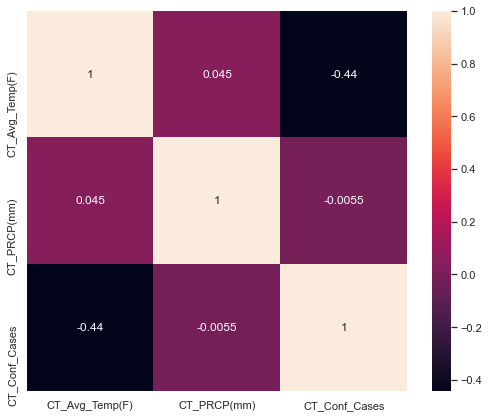

In [50]:
sns.set(rc={'figure.figsize':(9,7)})
sns.heatmap(CT.corr(), square=True, cmap='rocket', annot = True)

In [51]:
MA = df7[['MA_Avg_Temp(F)', 'MA_PRCP(mm)', 'MA_Conf_Cases']]

<AxesSubplot:>

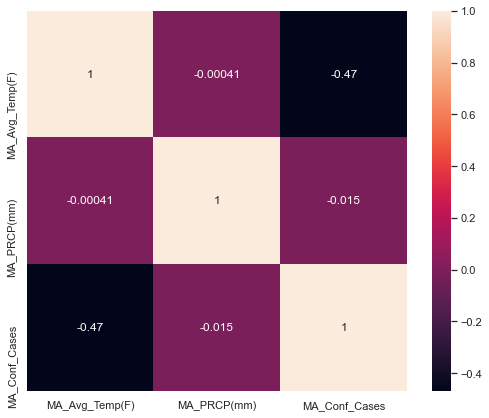

In [52]:
sns.heatmap(MA.corr(), square=True, cmap='rocket', annot=True)

In [53]:
VT= df7[['VT_Avg_Temp(F)', 'VT_PRCP(mm)', 'VT_Conf_Cases']]

<AxesSubplot:>

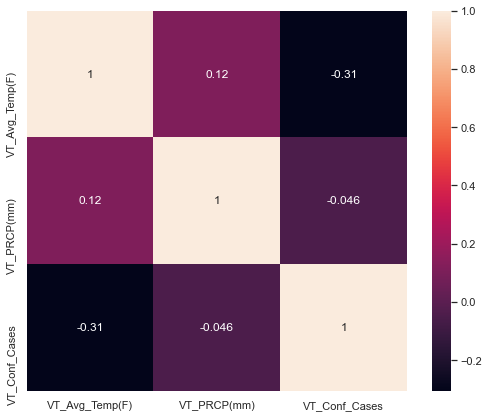

In [54]:
sns.heatmap(VT.corr(), square=True, cmap='rocket', annot=True)

In [55]:
ME = df7[['ME_Avg_Temp(F)', 'ME_PRCP(mm)', 'ME_Conf_Cases']]

<AxesSubplot:>

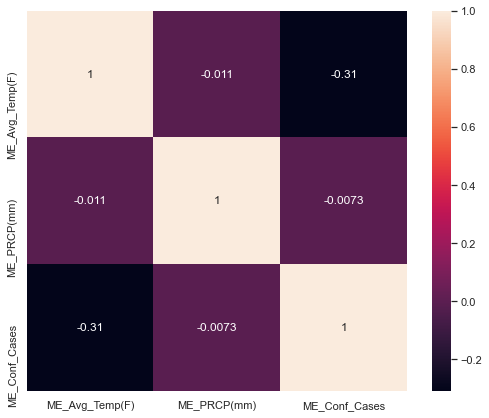

In [56]:
sns.heatmap(ME.corr(), square=True, cmap='rocket', annot=True)

In [ ]:
list_states = [MA, ME, CT, VT]

In [ ]:
interpolated_features = pd.DataFrame()
cols = [ , , , , ]
shift_dict = {'2w_ks': 14, '4wks':28, '6wks':42}
for col in cols:
    for key in shift_dict.keys():
        periods = shift_dict[key]
        temp[col+'_'+key] = temp[col].shift(periods=periods).copy().fillna(method='bfill')
        temp = temp.resample('W').mean()
        interpolated_features = pd.concat([site_interpolated, temp])

In [ ]:
MA2 = MA 

In [ ]:
#df['SPX_Ret'] = df['SPX_Prices'].pct_change()

In [ ]:
MA2['temp_change'] =MA2['MA_Avg_Temp(F)'].diff()

In [ ]:
MA2=MA2.iloc[1:,:]

In [ ]:
sns.heatmap(MA2.corr(), square=True, annot=True)
plt.yticks(rotation =45)

In [ ]:
AUTOCORRELATION: Correlation of a series with a lagged copy of itself (usually we mean lag 1)
* For daily data, lag 1 would be the series lagged by one day

In [ ]:
MA.info()

In [ ]:
MA2 = MA

In [ ]:
MA2.asfreq('d')

In [ ]:
MA2

In [ ]:
MA2[MA2.index.duplicated()]

In [ ]:
MA2.loc['2020-11-30']

In [ ]:
ME[ME.index.duplicated()]

In [ ]:
ME.loc['2020-11-30']

In [ ]:
VT[VT.index.duplicated()]

In [ ]:
CT[CT.index.duplicated()]